In [51]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [52]:
from pyspark.ml.clustering import KMeans    # https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.KMeans.html
from pyspark.ml.classification import RandomForestClassifier    # https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.tree.RandomForest.html

kMeans = KMeans()
randomForest = RandomForestClassifier()
raw_data = spark.read.csv("Data/data.csv", header=True, inferSchema=True)

organizing

In [53]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
import pyspark.sql.functions as F
from pyspark.sql.functions import col, lit
import functools

stringIndexer = StringIndexer(inputCol="Class", outputCol="Label")
model = stringIndexer.fit(raw_data)
OD = model.transform(raw_data)
OD = OD.drop("Class")
OD.show(5)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|  2.0|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.006978659| 0.00356362

scaling

In [54]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType

ND = OD.select("*")

for column in OD.columns:
    if column == "Class" or column == "Label":
        continue

    column_max = OD.agg({column: "max"}).collect()[0][0]
    column_min = OD.agg({column: "min"}).collect()[0][0]

    scaler = udf(lambda x: (x-column_min)/(column_max-column_min), FloatType())
    ND = ND.withColumn(column, scaler(col(column)))

Cluster

OD CLUSTERING

In [55]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

CLASS_SIZE = raw_data.select("Class").distinct().count()
print(f"Class size = {CLASS_SIZE}")

featuresCol = OD.columns[:-1]
predictionCol = OD.columns[-1]


vecAssembler = VectorAssembler(inputCols=featuresCol, outputCol="features")
temp_df = vecAssembler.transform(OD)

kMeans = KMeans(k=CLASS_SIZE)
model = kMeans.fit(temp_df.select("features"))

COD = model.transform(temp_df)
COD = COD.drop("features")
COD.show(5)

Class size = 7
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+----------+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|prediction|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+----------+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|  2.0|         3|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0

Best correlated column is Perimeter


<AxesSubplot:xlabel='Label', ylabel='Perimeter'>

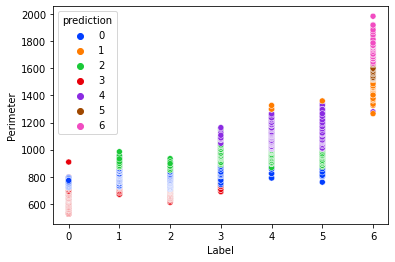

In [58]:
import seaborn as sns

cod_df = COD.toPandas()
best_correlated_column = cod_df.corr().loc["Label"].drop("Label").idxmax()
print(f"Best correlated column is {best_correlated_column}")
sns.scatterplot(data=cod_df, x="Label", y=best_correlated_column, hue="prediction", palette="bright")

ND CLUSTERING

In [60]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

CLASS_SIZE = raw_data.select("Class").distinct().count()
print(f"Class size = {CLASS_SIZE}")

featuresCol = ND.columns[:-1]
predictionCol = ND.columns[-1]


vecAssembler = VectorAssembler(inputCols=featuresCol, outputCol="features")
temp_df = vecAssembler.transform(ND)

kMeans = KMeans(k=CLASS_SIZE)
model = kMeans.fit(temp_df.select("features"))

CND = model.transform(temp_df)
CND = CND.drop("features")
CND.show(2)

Class size = 7
+-----------+----------+---------------+---------------+------------+------------+-----------+-------------+---------+----------+----------+-----------+------------+------------+------------+------------+-----+----------+
|       Area| Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity| ConvexArea|EquivDiameter|   Extent|  Solidity| roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|prediction|
+-----------+----------+---------------+---------------+------------+------------+-----------+-------------+---------+----------+----------+-----------+------------+------------+------------+------------+-----+----------+
|0.034052674|0.05857388|     0.04426214|     0.15214169|  0.12261211|  0.47779703|0.033107013|  0.070804134|0.6710237|0.92282385|0.93482256| 0.78673315|   0.5934316|   0.8330487|  0.75099635|  0.98061985|  2.0|         1|
| 0.03550018|0.07755673|    0.030478805|     0.17833667|  0.05157739|    0.278472| 0.03499095|  0

Best correlated column is Perimeter


<AxesSubplot:xlabel='Label', ylabel='Perimeter'>

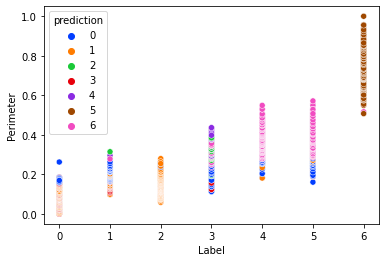

In [65]:
cnd_df = CND.toPandas()
best_correlated_column = cnd_df.corr().loc["Label"].drop("Label").idxmax()
print(f"Best correlated column is {best_correlated_column}")
sns.scatterplot(data=cnd_df, x="Label", y=best_correlated_column, hue="prediction", palette="bright")

In [7]:
# COD PURITY

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictionAndLabels = COD.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
dataset = spark.createDataFrame(predictionAndLabels.collect(), ["prediction", "label"])
evaluator = MulticlassClassificationEvaluator()
print(evaluator.evaluate(dataset))

# CND PURITY

predictionAndLabels = CND.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
dataset = spark.createDataFrame(predictionAndLabels.collect(), ["prediction", "label"])
evaluator = MulticlassClassificationEvaluator()
print(evaluator.evaluate(dataset))

0.11415567633571425
0.04894463491429017


Classification

In [8]:
# Classification
# OD

featuresCol = OD.columns[:-1]
vecAssembler = VectorAssembler(inputCols=featuresCol, outputCol="features")
temp_df = vecAssembler.transform(OD)

train_set, test_set = temp_df.randomSplit([0.8, 0.2], seed=0)
train_set, val_set = train_set.randomSplit([0.8, 0.2], seed=0)

depths = [2, 5, 10]
num_trees = [5, 10, 20]
best_score = 0
best_model = None
best_params = []

for depth in depths:
    for num_tree in num_trees:
        rf = RandomForestClassifier(numTrees=num_tree, maxDepth=depth, featuresCol='features', labelCol="Label", predictionCol='prediction', leafCol="leafId")
        model = rf.fit(train_set)
        preds = model.transform(val_set)

        predictionAndLabels = preds.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
        dataset = spark.createDataFrame(predictionAndLabels.collect(), ["prediction", "label"])
        evaluator = MulticlassClassificationEvaluator()
        score = evaluator.evaluate(dataset)
        if score > best_score:
            best_score = score
            best_model = model
            best_params = [depth, num_tree]
        print(f"Score = {score} with number of {num_tree} with {depth} depth.")

# Test Eval
truths = best_model.transform(test_set)
truthsAndLabels = truths.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
test_dataset = spark.createDataFrame(truthsAndLabels.collect(), ["prediction", "label"])
test_score = evaluator.evaluate(test_dataset)
precision = evaluator.evaluate(test_dataset, {evaluator.metricName: "precisionByLabel"})
recall = evaluator.evaluate(test_dataset, {evaluator.metricName: "recallByLabel"})
f1_score = evaluator.evaluate(test_dataset, {evaluator.metricName: "f1"})
print(f"Test Accuracy: {test_score}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1_score}")
print(f"Best Parameters: Depth = {best_params[0]}, Number of Trees = {best_params[1]}")

Score = 0.7188107236078618 with number of 5 with 2 depth.
Score = 0.7130552773625666 with number of 10 with 2 depth.
Score = 0.714046993002339 with number of 20 with 2 depth.
Score = 0.8801187245398434 with number of 5 with 5 depth.
Score = 0.8945162568305485 with number of 10 with 5 depth.
Score = 0.8844920448416866 with number of 20 with 5 depth.
Score = 0.9153417653829016 with number of 5 with 10 depth.
Score = 0.9196526884884596 with number of 10 with 10 depth.
Score = 0.9230682541761277 with number of 20 with 10 depth.
Test Accuracy: 0.918853794459775
Test Precision: 0.911957950065703
Test Recall: 0.9378378378378378
Test F1-Score: 0.918853794459775
Best Parameters: Depth = 10, Number of Trees = 20


In [9]:
test_set.show(5)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+--------------------+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|            features|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+--------------------+
|21877|  542.194|    202.0161551|    138.0740299| 1.463100304| 0.729969108|     22107|  166.8971585|0.747165301|0.989596056| 0.93516494|0.826157484|  0.00923418| 0.002653563| 0.682536189| 0.998618906|  0.0|[21877.0,542.194,...|
|21961|  551.696|    204.7763134|    136.7099579|  1.49788879| 0.744514487|     22267|  

In [10]:
# Classification
# ND

featuresCol = ND.columns[:-1]
vecAssembler = VectorAssembler(inputCols=featuresCol, outputCol="features")
temp_df = vecAssembler.transform(ND)

train_set, test_set = temp_df.randomSplit([0.8, 0.2], seed=0)
train_set, val_set = train_set.randomSplit([0.8, 0.2], seed=0)


depths = [2, 5, 10]
num_trees = [5, 10, 20]
best_score = 0
best_model = None
best_params = []


for depth in depths:
    for num_tree in num_trees:
        rf = RandomForestClassifier(numTrees=num_tree, maxDepth=depth, featuresCol='features', labelCol="Label", predictionCol='prediction', leafCol="leafId")
        model = rf.fit(train_set)
        preds = model.transform(val_set)

        predictionAndLabels = preds.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
        dataset = spark.createDataFrame(predictionAndLabels.collect(), ["prediction", "label"])
        evaluator = MulticlassClassificationEvaluator()
        score = evaluator.evaluate(dataset)
        if score > best_score:
            best_score = score
            best_model = model
            best_params = [depth, num_tree]
        print(f"Score = {score} with number of {num_tree} with {depth} depth.")

# Test Eval
truths = best_model.transform(test_set)
truthsAndLabels = truths.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
test_dataset = spark.createDataFrame(truthsAndLabels.collect(), ["prediction", "label"])
test_score = evaluator.evaluate(test_dataset)
precision = evaluator.evaluate(test_dataset, {evaluator.metricName: "precisionByLabel"})
recall = evaluator.evaluate(test_dataset, {evaluator.metricName: "recallByLabel"})
f1_score = evaluator.evaluate(test_dataset, {evaluator.metricName: "f1"})
print(f"Test Accuracy: {test_score}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1_score}")
print(f"Best Parameters: Depth = {best_params[0]}, Number of Trees = {best_params[1]}")

Score = 0.7188107236078618 with number of 5 with 2 depth.
Score = 0.7130552773625666 with number of 10 with 2 depth.
Score = 0.714046993002339 with number of 20 with 2 depth.
Score = 0.8801187245398434 with number of 5 with 5 depth.
Score = 0.8945162568305485 with number of 10 with 5 depth.
Score = 0.8844920448416866 with number of 20 with 5 depth.
Score = 0.9153417653829016 with number of 5 with 10 depth.
Score = 0.9196526884884596 with number of 10 with 10 depth.
Score = 0.9230682541761277 with number of 20 with 10 depth.
Test Accuracy: 0.918853794459775
Test Precision: 0.911957950065703
Test Recall: 0.9378378378378378
Test F1-Score: 0.918853794459775
Best Parameters: Depth = 10, Number of Trees = 20


In [11]:
# Classification
# COD

COD = COD.drop("prediction")
featuresCol = COD.columns[:-1]
vecAssembler = VectorAssembler(inputCols=featuresCol, outputCol="features")
temp_df = vecAssembler.transform(COD)

train_set, test_set = temp_df.randomSplit([0.8, 0.2], seed=0)
train_set, val_set = train_set.randomSplit([0.8, 0.2], seed=0)


depths = [2, 5, 10]
num_trees = [5, 10, 20]
best_score = 0
best_model = None
best_params = []


for depth in depths:
    for num_tree in num_trees:
        rf = RandomForestClassifier(numTrees=num_tree, maxDepth=depth, featuresCol='features', labelCol="Label", predictionCol='prediction', leafCol="leafId")
        model = rf.fit(train_set)
        preds = model.transform(val_set)

        predictionAndLabels = preds.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
        dataset = spark.createDataFrame(predictionAndLabels.collect(), ["prediction", "label"])
        evaluator = MulticlassClassificationEvaluator()
        score = evaluator.evaluate(dataset)
        if score > best_score:
            best_score = score
            best_model = model
            best_params = [depth, num_tree]
        print(f"Score = {score} with number of {num_tree} with {depth} depth.")

# Test Eval
truths = best_model.transform(test_set)
truthsAndLabels = truths.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
test_dataset = spark.createDataFrame(truthsAndLabels.collect(), ["prediction", "label"])
test_score = evaluator.evaluate(test_dataset)
precision = evaluator.evaluate(test_dataset, {evaluator.metricName: "precisionByLabel"})
recall = evaluator.evaluate(test_dataset, {evaluator.metricName: "recallByLabel"})
f1_score = evaluator.evaluate(test_dataset, {evaluator.metricName: "f1"})
print(f"Test Accuracy: {test_score}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1_score}")
print(f"Best Parameters: Depth = {best_params[0]}, Number of Trees = {best_params[1]}")

Score = 0.7188107236078618 with number of 5 with 2 depth.
Score = 0.7130552773625666 with number of 10 with 2 depth.
Score = 0.714046993002339 with number of 20 with 2 depth.
Score = 0.8801187245398434 with number of 5 with 5 depth.
Score = 0.8945162568305485 with number of 10 with 5 depth.
Score = 0.8844920448416866 with number of 20 with 5 depth.
Score = 0.9153417653829016 with number of 5 with 10 depth.
Score = 0.9196526884884596 with number of 10 with 10 depth.
Score = 0.9230682541761277 with number of 20 with 10 depth.
Test Accuracy: 0.918853794459775
Test Precision: 0.911957950065703
Test Recall: 0.9378378378378378
Test F1-Score: 0.918853794459775
Best Parameters: Depth = 10, Number of Trees = 20


In [12]:
# Classification
# CND

CND = CND.drop("prediction")
featuresCol = CND.columns[:-1]
vecAssembler = VectorAssembler(inputCols=featuresCol, outputCol="features")
temp_df = vecAssembler.transform(CND)

train_set, test_set = temp_df.randomSplit([0.8, 0.2], seed=0)
train_set, val_set = train_set.randomSplit([0.8, 0.2], seed=0)

depths = [2, 5, 10]
num_trees = [5, 10, 20]
best_score = 0
best_model = None
best_params = []


for depth in depths:
    for num_tree in num_trees:
        rf = RandomForestClassifier(numTrees=num_tree, maxDepth=depth, featuresCol='features', labelCol="Label", predictionCol='prediction', leafCol="leafId")
        model = rf.fit(val_set)
        preds = model.transform(test_set)

        predictionAndLabels = preds.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
        dataset = spark.createDataFrame(predictionAndLabels.collect(), ["prediction", "label"])
        evaluator = MulticlassClassificationEvaluator()
        score = evaluator.evaluate(dataset)
        if score > best_score:
            best_score = score
            best_model = model
            best_params = [depth, num_tree]
        print(f"Score = {score} with number of {num_tree} with {depth} depth.")

# Test Eval
truths = best_model.transform(test_set)
truthsAndLabels = truths.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
test_dataset = spark.createDataFrame(truthsAndLabels.collect(), ["prediction", "label"])
test_score = evaluator.evaluate(test_dataset)
precision = evaluator.evaluate(test_dataset, {evaluator.metricName: "precisionByLabel"})
recall = evaluator.evaluate(test_dataset, {evaluator.metricName: "recallByLabel"})
f1_score = evaluator.evaluate(test_dataset, {evaluator.metricName: "f1"})
print(f"Test Accuracy: {test_score}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1_score}")
print(f"Best Parameters: Depth = {best_params[0]}, Number of Trees = {best_params[1]}")

Score = 0.6946522438132859 with number of 5 with 2 depth.
Score = 0.7164095843993565 with number of 10 with 2 depth.
Score = 0.7229497615048558 with number of 20 with 2 depth.
Score = 0.8823230815005929 with number of 5 with 5 depth.
Score = 0.8764774710582534 with number of 10 with 5 depth.
Score = 0.8840494660218254 with number of 20 with 5 depth.
Score = 0.8999949923865609 with number of 5 with 10 depth.
Score = 0.9130167131662846 with number of 10 with 10 depth.
Score = 0.9132306960010721 with number of 20 with 10 depth.
Test Accuracy: 0.9132306960010721
Test Precision: 0.9087301587301587
Test Recall: 0.9283783783783783
Test F1-Score: 0.9132306960010721
Best Parameters: Depth = 10, Number of Trees = 20
